This notebook will explore a dataset provided by Kaggle for housing price prediction.
First we will implement a random forest model to get a baseline and then we will implement a more complex neural network solution.

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
data_path = "./train.csv" # Relative path to the training dataset, equivalent to /mnt/c/Users/ekc/Documents/homespace/train.csv
df = pd.read_csv(data_path)

In [4]:
df.shape

(1460, 81)

In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df.drop("Id", axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [8]:
labels = df["SalePrice"]
df.drop("SalePrice", axis=1, inplace=True)
X_train, X_dev, Y_train, Y_dev = train_test_split(df, labels, test_size=0.3, random_state=53)

In [9]:
X_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 438 entries, 631 to 209
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     438 non-null    int64  
 1   MSZoning       438 non-null    object 
 2   LotFrontage    366 non-null    float64
 3   LotArea        438 non-null    int64  
 4   Street         438 non-null    object 
 5   Alley          23 non-null     object 
 6   LotShape       438 non-null    object 
 7   LandContour    438 non-null    object 
 8   Utilities      438 non-null    object 
 9   LotConfig      438 non-null    object 
 10  LandSlope      438 non-null    object 
 11  Neighborhood   438 non-null    object 
 12  Condition1     438 non-null    object 
 13  Condition2     438 non-null    object 
 14  BldgType       438 non-null    object 
 15  HouseStyle     438 non-null    object 
 16  OverallQual    438 non-null    int64  
 17  OverallCond    438 non-null    int64  
 18  YearBuilt    

In [10]:
train_df = pd.concat([X_train, Y_train], axis=1)
dev_df = pd.concat([X_dev, Y_dev], axis=1)

In [11]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 438 entries, 631 to 209
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     438 non-null    int64  
 1   MSZoning       438 non-null    object 
 2   LotFrontage    366 non-null    float64
 3   LotArea        438 non-null    int64  
 4   Street         438 non-null    object 
 5   Alley          23 non-null     object 
 6   LotShape       438 non-null    object 
 7   LandContour    438 non-null    object 
 8   Utilities      438 non-null    object 
 9   LotConfig      438 non-null    object 
 10  LandSlope      438 non-null    object 
 11  Neighborhood   438 non-null    object 
 12  Condition1     438 non-null    object 
 13  Condition2     438 non-null    object 
 14  BldgType       438 non-null    object 
 15  HouseStyle     438 non-null    object 
 16  OverallQual    438 non-null    int64  
 17  OverallCond    438 non-null    int64  
 18  YearBuilt    

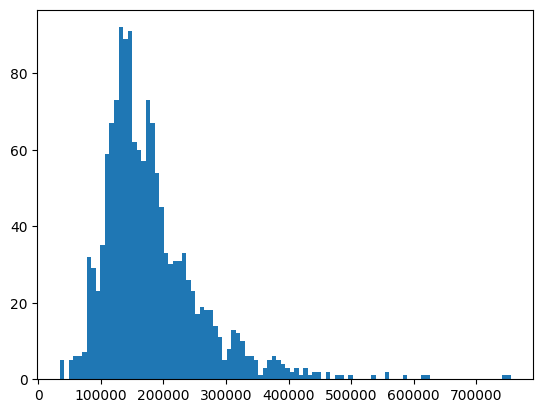

In [21]:
plt.hist(labels, bins=100)
plt.show()

In [15]:
RF_model = tfdf.keras.RandomForestModel(
    task=tfdf.keras.Task.REGRESSION,   # Define the task (Regression)
    num_trees=300,                    # Number of trees in the forest
    max_depth=10,                     # Maximum depth of trees
    min_examples=5,                   # Minimum number of examples per leaf node
    categorical_algorithm="CART",     # CART algorithm for categorical features
    compute_oob_variable_importances=True,  # Compute out-of-bag variable importances
)

Use /tmp/tmpfrsow3f5 as temporary training directory


In [16]:
RF_model.fit(tfdf.keras.pd_dataframe_to_tf_dataset(train_df, task=tfdf.keras.Task.REGRESSION, label="SalePrice"))

Reading training dataset...
Training dataset read in 0:00:00.900973. Found 1022 examples.
Training model...


I0000 00:00:1746016413.917430  256541 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1746016413.917656  256541 kernel.cc:783] Collect training examples
I0000 00:00:1746016413.917675  256541 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1746016413.917885  256541 kernel.cc:401] Number of batches: 2
I0000 00:00:1746016413.917915  256541 kernel.cc:402] Number of examples: 1022
I0000 00:00:1746016413.919352  256541 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (3 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1746016413.919425  256541 data_spec_inference.cc:354] 1 item(s) have been prun

Model trained in 0:00:03.096874
Compiling model...


I0000 00:00:1746016416.996338  256541 decision_forest.cc:808] Model loaded with 300 root(s), 71754 node(s), and 74 input feature(s).
I0000 00:00:1746016416.996569  256541 abstract_model.cc:1439] Engine "RandomForestOptPred" built
2025-04-30 14:33:36.996653: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.


In [17]:
inspector = RF_model.make_inspector()
training_metrics = inspector.evaluation()
print(training_metrics)

Evaluation(num_examples=1022, accuracy=None, loss=None, rmse=28568.262521484543, ndcg=None, aucs=None, auuc=None, qini=None)


In [23]:
print(RF_model.task)

2


In [24]:
RF_results = RF_model.evaluate(tfdf.keras.pd_dataframe_to_tf_dataset(train_df, task=tfdf.keras.Task.REGRESSION, label="SalePrice"), return_dict=True)

2/2 [==============================] - 1s 11ms/step - loss: 0.0000e+00


In [25]:
print(RF_results)

{'loss': 0.0}
